### 10. Нарисовать векторное поле для автокодировщика. Нарисовать heatmap по правдоподобию объектов выборки, получаемым с помощью вариационного автокодировщика. Сопоставить результаты. Выборки: несколько синтетических 2d выборок, аналогичных по сложности визуализированным в статье.


In [178]:
import os
import pickle
import numpy as np
import math
import torch.distributions as dist
import matplotlib.pyplot as plt
from matplotlib import cm as cm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torchvision.utils import make_grid
from scipy import stats
from collections import defaultdict
from tqdm import tqdm
USE_CUDA = torch.cuda.is_available()

print('cuda is available:', USE_CUDA)

cuda is available: True


#### VAE

In [2]:
def train_epoch(model, train_loader, optimizer, use_cuda, loss_key='total'):
    model.train()
  
    stats = defaultdict(list)
    for x in train_loader:
        if use_cuda:
            x = x.cuda()
        losses = model.loss(x)
        optimizer.zero_grad()
        losses[loss_key].backward()
        optimizer.step()

        for k, v in losses.items():
            stats[k].append(v.item())
    return stats


def eval_model(model, data_loader, use_cuda):
    model.eval()
    stats = defaultdict(float)
    with torch.no_grad():
        for x in data_loader:
            if use_cuda:
                x = x.cuda()
            losses = model.loss(x)
            for k, v in losses.items():
                stats[k] += v.item() * x.shape[0]

        for k in stats.keys():
            stats[k] /= len(data_loader.dataset)
    return stats


def train_model(model, train_loader, test_loader, epochs, lr, use_tqdm=False, use_cuda=False, loss_key='total_loss'):
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = defaultdict(list)
    test_losses = defaultdict(list)
    forrange = tqdm(range(epochs)) if use_tqdm else range(epochs)
    if use_cuda:
        model = model.cuda()
    for epoch in forrange:
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, use_cuda, loss_key)
        test_loss = eval_model(model, test_loader, use_cuda)
        for k in train_loss.keys():
            train_losses[k].extend(train_loss[k])
            test_losses[k].append(test_loss[k])
    return dict(train_losses), dict(test_losses)


def plot_training_curves(train_losses, test_losses):
    n_train = len(train_losses[list(train_losses.keys())[0]])
    n_test = len(test_losses[list(train_losses.keys())[0]])
    x_train = np.linspace(0, n_test - 1, n_train)
    x_test = np.arange(n_test)

    plt.figure()
    for key, value in train_losses.items():
        plt.plot(x_train, value, label=key + '_train')

    for key, value in test_losses.items():
        plt.plot(x_test, value, label=key + '_test')

    plt.legend(fontsize=12)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()
    
def get_normal_KL(mean_1, log_std_1, mean_2=None, log_std_2=None):

    if mean_2 is None:
        mean_2 = torch.zeros_like(mean_1)
    if log_std_2 is None:
        log_std_2 = torch.zeros_like(log_std_1)

    out = log_std_2-log_std_1+ (torch.exp(log_std_1)**2 + (mean_1 - mean_2)**2)/ (2 * torch.exp(log_std_2)**2) - 1/2
    return out



def get_normal_nll(x, mean, log_std):

    LL = (torch.log(2*math.pi*(torch.exp(log_std)**2))/2 + ((x-mean)**2)/(2 * (torch.exp(log_std)**2)))
    return LL



class FullyConnectedMLP(nn.Module):
    def __init__(self, input_shape, hiddens, output_shape):
        assert isinstance(hiddens, list)
        super().__init__()
        self.input_shape = (input_shape,)
        self.output_shape = (output_shape,)
        self.hiddens = hiddens

        model = []
        prev_h = input_shape
        for h in hiddens:
            # ====
            model.append(nn.Linear(prev_h, h))
            model.append(nn.ReLU())

            prev_h = h
        model.append(nn.Linear(hiddens[-1], output_shape))
        self.net = nn.Sequential(*model)

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        return self.net(x).view(batch_size, *self.output_shape)

class VAE2d(nn.Module):
    def __init__(self, n_in, n_latent, enc_hidden_sizes, dec_hidden_sizes):
        assert isinstance(enc_hidden_sizes, list)
        assert isinstance(dec_hidden_sizes, list)
        super().__init__()
        self.n_latent = n_latent
        self.encoder = FullyConnectedMLP(n_in, enc_hidden_sizes, 2 * n_latent)
        self.decoder = FullyConnectedMLP(n_latent, dec_hidden_sizes, 2 * n_in)


    def prior(self, n):
        return torch.normal(0,1,n)

    def forward(self, x):
        mu_z, log_std_z = torch.chunk((self.encoder(x)), 2, dim=1)
        z_sigma = torch.exp(log_std_z)
        eps = self.prior(z_sigma.shape).cuda()
        z = z_sigma * eps + mu_z
        mu_x, log_std_x = torch.chunk((self.decoder(z)), 2, dim=1) 
        normal = dist.normal.Normal(0, 1)
        x_normal = self.prior(torch.exp(log_std_x).shape).cuda()
        x_rec = torch.exp(log_std_x) * x_normal + mu_x
        posterior_log_prob = normal.log_prob(x_rec)
        lkh2.append((posterior_log_prob.cpu().detach().numpy()))
        dots.append(x_rec.cpu().detach().numpy())

        return mu_z, log_std_z, mu_x, log_std_x

    def loss(self, x):
        mu_z, log_std_z, mu_x, log_std_x = self(x)

        recon_loss = get_normal_nll(x, log_std_x, mu_x).mean().cuda()
        kl_loss = get_normal_KL(mu_z, log_std_z, mu_x, log_std_x).mean().cuda()
        return {
            'elbo_loss': recon_loss + kl_loss, 
            'recon_loss': recon_loss,
            'kl_loss': kl_loss
        }

    def sample(self, n, noise=True):
        with torch.no_grad():
            z = torch.normal(torch.zeros(n), torch.eye(n)).cuda()
            mu, log_std = self.decoder(z).chunk(2, dim=1)
            if noise:
                z = torch.randn_like(mu) * log_std.exp() + mu
            else:
                z = mu
        return z.cpu().numpy()


def solve_task(train_data, test_data, model, batch_size, epochs, lr, use_cuda=False, use_tqdm=False):
    train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)

    train_losses, test_losses = train_model(
        model, train_loader, test_loader, epochs=EPOCHS, lr=LR, use_cuda=use_cuda, use_tqdm=use_tqdm, loss_key='elbo_loss'
    )
    samples_noise = model.sample(300, noise=True)
    samples_nonoise = model.sample(300, noise=False)

    for key, value in test_losses.items():
        print('{}: {:.4f}'.format(key, value[-1]))

    plot_training_curves(train_losses, test_losses)

#### Выборка - многомодовое и одномодовое нормальное распределение

In [128]:
def visualize_2d_data(train_data, test_data, train_labels=None, test_labels=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.set_title('train', fontsize=16)
    ax1.scatter(train_data[:, 0], train_data[:, 1], s=1, c=train_labels)
    ax1.tick_params(labelsize=16)
    ax2.set_title('test', fontsize=16)
    ax2.scatter(test_data[:, 0], test_data[:, 1], s=1, c=test_labels)
    ax2.tick_params(labelsize=16)
    plt.show()

def generate_2d_data(count, mode='univariate'):
    assert mode in ['univariate', 'multivariate']
    np.random.seed(42)
    mean = np.array([[2.0, 3.0]])
    sigma = [[3.0, 0.5]]
    if mode == 'univariate':
        rotate = [
            [1.0, 0], 
            [0, 1.0]
        ]
        data = (mean + (np.random.randn(count, 2) * sigma).dot(rotate))
    else:
        rotate = [
            [0.1, 0.9], 
            [0.9, 0.1]
        ]
        data = ((np.concatenate((mean + (np.random.randn(count, 2) * sigma).dot(rotate),mean + (np.random.randn(count, 2) *0.8* sigma) ))))
        np.random.shuffle(data)
    data = data.astype('float32')
    split = int(0.9 * count)
    train_data, test_data = data[:split], data[split:]
    return train_data, test_data


### Выполнение:
##### Хотелось получить векторное поле, как в следующей статье (https://arxiv.org/pdf/1907.02796.pdf), но не удалось достать градиенты из loss'a. Поэтому вектора поля указывают на направление возрастания правдоподобия.


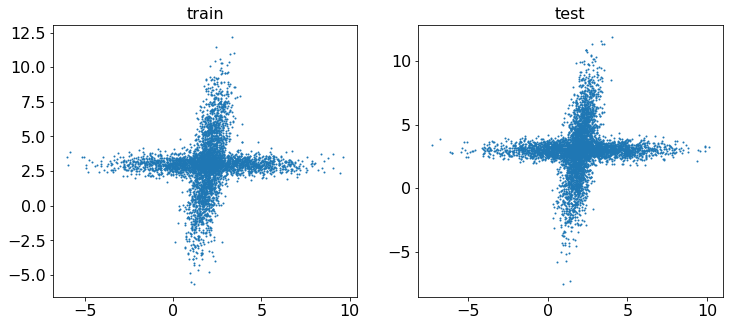

elbo_loss: 2.6601
recon_loss: 2.3920
kl_loss: 0.2680


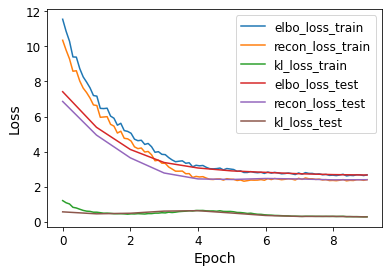

In [232]:
torch.manual_seed(11)

ENC_HIDDEN_SIZES = [2]
DEC_HIDDEN_SIZES = [2]
BATCH_SIZE = 512
EPOCHS = 10
LR = 0.01
lkh2 = []
dots = []
COUNT = 5000
train_data, test_data = generate_2d_data(COUNT, mode='multivariate')
visualize_2d_data(train_data, test_data)

model = VAE2d(2, 2, ENC_HIDDEN_SIZES, DEC_HIDDEN_SIZES).cuda()
solve_task(train_data, test_data, model, BATCH_SIZE, EPOCHS, LR, use_cuda=USE_CUDA)

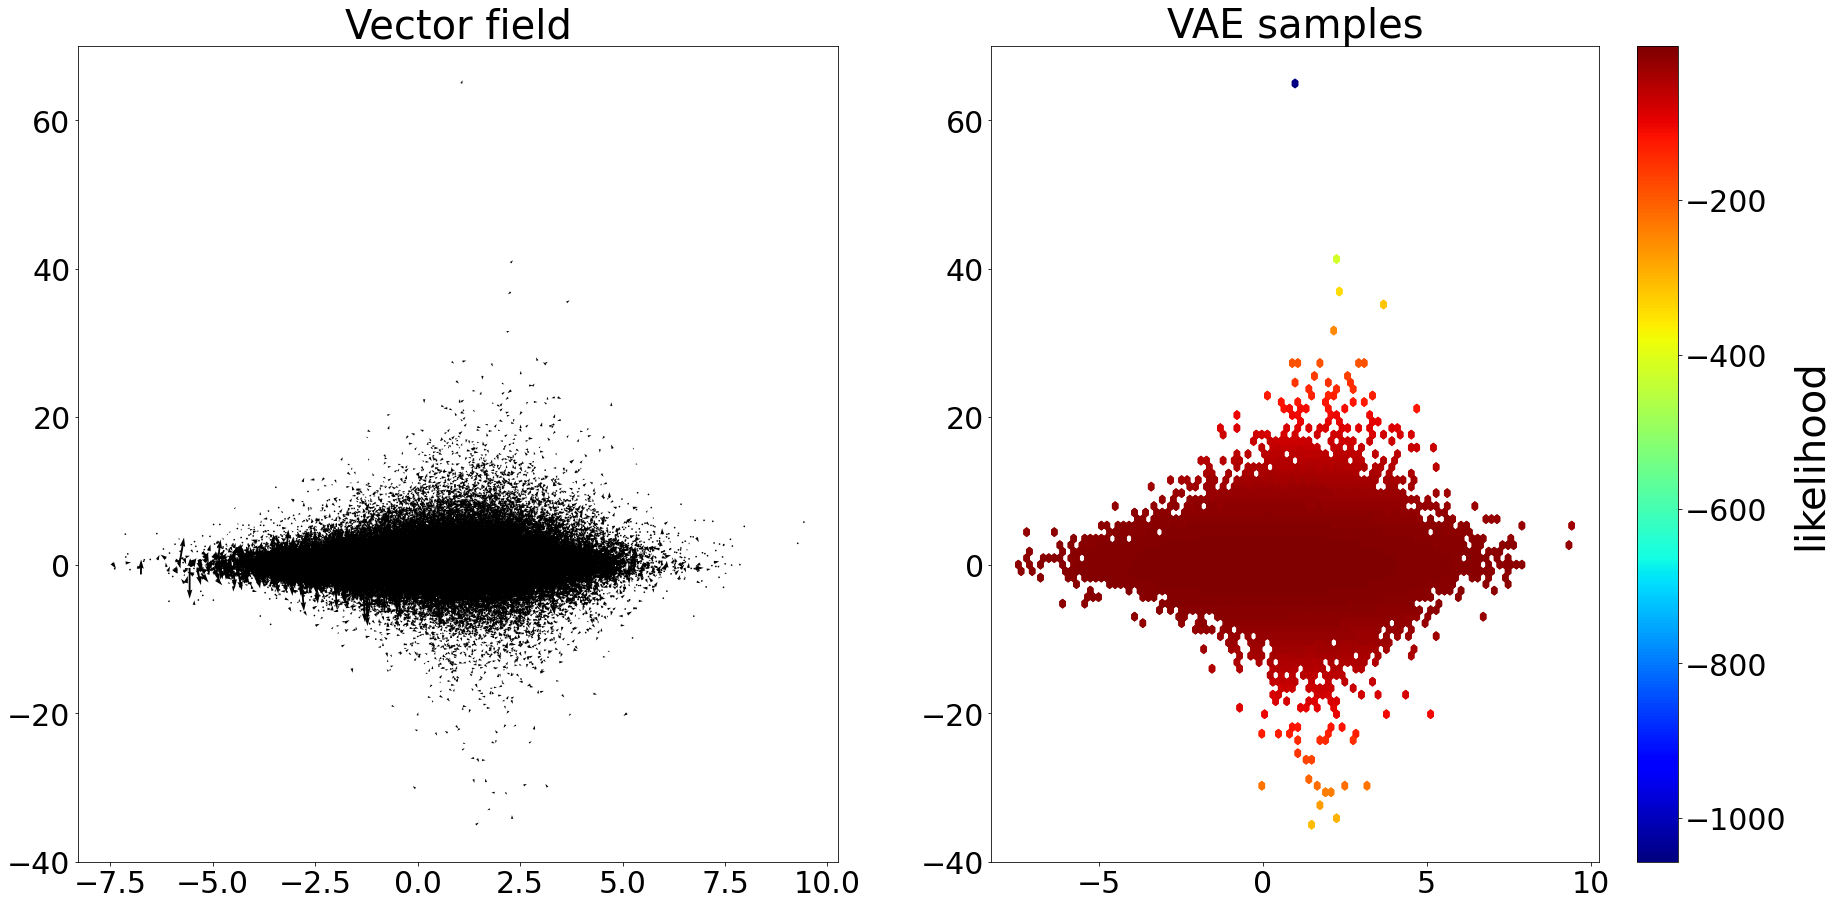

In [235]:
U = np.concatenate( lkh2, axis=0)[:,0]
V = np.concatenate( lkh2, axis=0)[:,1]
x = np.concatenate( dots, axis=0)[:,0].ravel()
y = np.concatenate( dots, axis=0)[:,1].ravel()
z = np.mean(np.concatenate( lkh2, axis=0),axis = 1) 


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15))
ax1.set_title('Vector field', fontsize=40)


# Не получилось достать градиенты из loss'а, так что направлял вектора в сторону возрастания правдоподобия

ax1.quiver(x, y, np.concatenate(([np.min(x)],x[sorted(range(len(z)),key=z.__getitem__)][1:])), 
           np.concatenate(([np.min(y)],y[sorted(range(len(z)),key=z.__getitem__)][1:])),scale = 500)
ax2.set_title('VAE samples', fontsize=40)
ax2.hexbin(x, y, C=z, cmap=cm.jet, bins=None)

cbar = fig.colorbar(ax2.hexbin(x, y, C=z, cmap=cm.jet, bins=None))
cbar.set_label('likelihood', fontsize=40)
cbar.ax.tick_params(labelsize=30)
ax1.tick_params( labelsize=30) 
ax2.tick_params( labelsize=30) 
plt.show()

#### Видим, что максимальное правдоподобие соответствует исходному распределению (данная итерация не самая идеальная, т.к. форма повторяется не полностью). Вектора должны указывать на исходное распределение, что в какой-то степени выполняется.

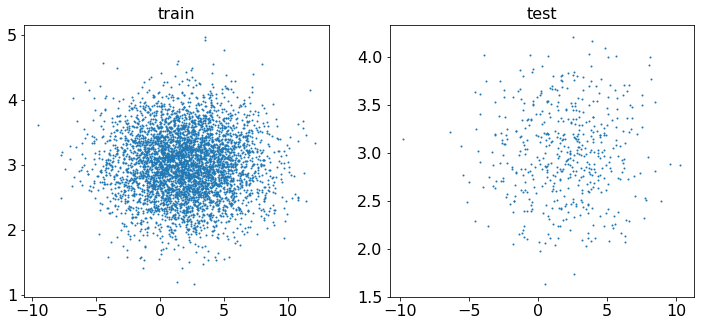

elbo_loss: 3.7819
recon_loss: 2.9352
kl_loss: 0.8466


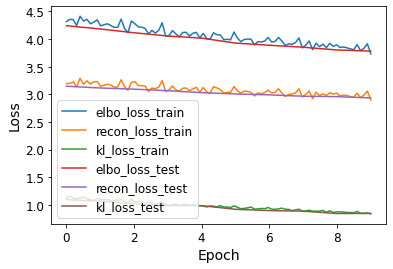

In [238]:
lkh2 = []
dots = []
ENC_HIDDEN_SIZES = [1]
DEC_HIDDEN_SIZES = [1]
BATCH_SIZE = 512
EPOCHS = 10
LR = 0.001
lkh2 = []
dots = []
COUNT = 5000
train_data, test_data = generate_2d_data(COUNT, mode='univariate')
visualize_2d_data(train_data, test_data)

model = VAE2d(2, 2, ENC_HIDDEN_SIZES, DEC_HIDDEN_SIZES).cuda()
solve_task(train_data, test_data, model, BATCH_SIZE, EPOCHS, LR, use_cuda=USE_CUDA)

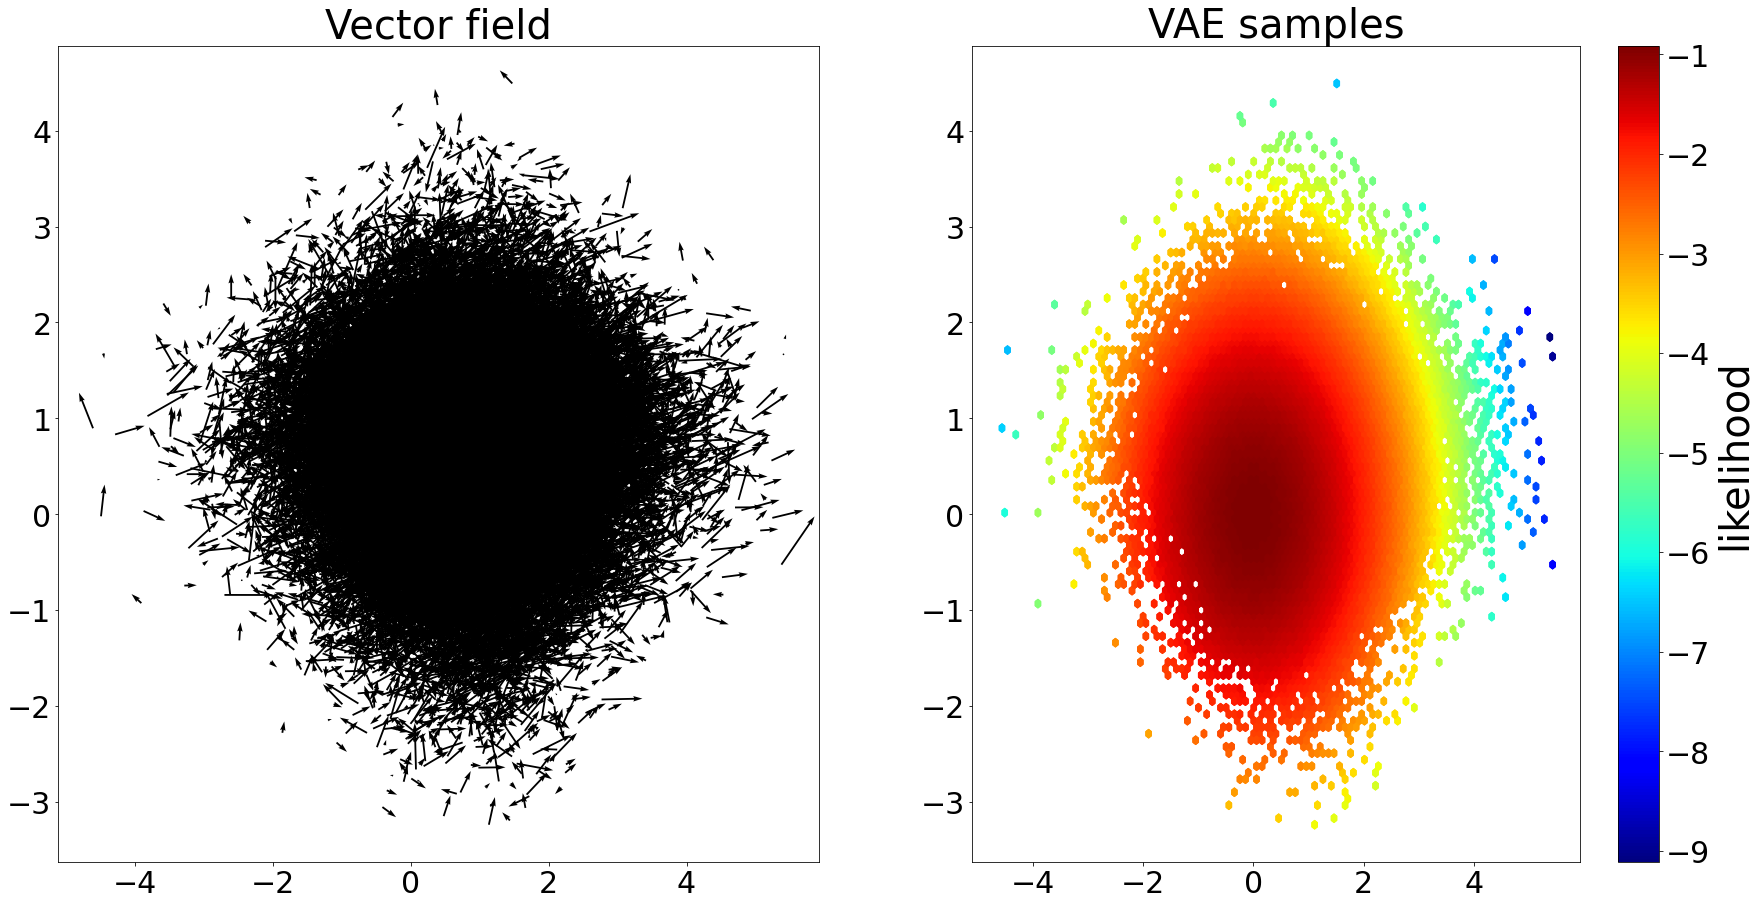

In [239]:
U = np.concatenate( lkh2, axis=0)[:,0]
V = np.concatenate( lkh2, axis=0)[:,1]
x = np.concatenate( dots, axis=0)[:,0].ravel()
y = np.concatenate( dots, axis=0)[:,1].ravel()
z = np.mean(np.concatenate( lkh2, axis=0),axis = 1) 






fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15))
ax1.set_title('Vector field', fontsize=40)
ax1.quiver(x, y, np.concatenate((x[sorted(range(len(z)),key=z.__getitem__)][1:], [np.max(x)])), 
           np.concatenate((y[sorted(range(len(z)),key=z.__getitem__)][1:], [np.max(x)])), scale = 50)
ax2.set_title('VAE samples', fontsize=40)
ax2.hexbin(x, y, C=z, cmap=cm.jet, bins=None)

cbar = fig.colorbar(ax2.hexbin(x, y, C=z, cmap=cm.jet, bins=None))
cbar.set_label('likelihood', fontsize=40)
cbar.ax.tick_params(labelsize=30)
ax1.tick_params( labelsize=30) 
ax2.tick_params( labelsize=30) 
plt.show()

#### Аналогично, правдоподобие соответствует действительности 
